# Notebook Maestro: Análisis temático y de sentimiento en entrevistas

Este notebook permite:
- Procesar múltiples entrevistas (.txt)
- Calcular frecuencias y exportarlas a .csv
- Construir una matriz documento-término (TF-IDF)
- Realizar análisis de sentimiento
- Aplicar clustering temático
- Visualizar resultados

## 1. Instalar e importar librerías necesarias

In [ ]:
!pip install -q nltk scikit-learn textblob
!python -m textblob.download_corpora

import nltk
import os
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
stopwords_esp = set(stopwords.words('spanish'))

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Subir múltiples archivos `.txt`

In [ ]:
from google.colab import files
uploaded = files.upload()
txt_files = [f for f in uploaded if f.endswith('.txt')]

Saving Voz 035.txt to Voz 035.txt
Saving Voz 036.txt to Voz 036.txt
Saving Voz_Prueba_Piloto_01.txt to Voz_Prueba_Piloto_01.txt


## 3. Procesar cada archivo: frecuencias, sentimiento y guardar CSV

In [ ]:
datos = []
corpus = []

for archivo in txt_files:
    with open(archivo, 'r', encoding='utf-8') as f:
        texto = f.read()
        corpus.append(texto)

    # Tokenización simple
    palabras = re.findall(r'\b\w+\b', texto.lower())
    tokens = [p for p in palabras if p not in stopwords_esp]
    frecuencias = Counter(tokens)

    # Exportar CSV por archivo
    df_frec = pd.DataFrame(frecuencias.items(), columns=['palabra', 'frecuencia'])
    df_frec['archivo'] = archivo
    df_frec.to_csv(archivo.replace('.txt', '_frecuencias.csv'), index=False)

    # Análisis de sentimiento con TextBlob
    sentimiento = TextBlob(texto).sentiment.polarity

    # Guardar datos básicos
    datos.append({
        'archivo': archivo,
        'texto': texto,
        'tokens': ' '.join(tokens),
        'sentimiento': sentimiento
    })

df_datos = pd.DataFrame(datos)
df_datos.to_csv("resumen_entrevistas.csv", index=False)

## 4. Construir matriz documento-término (TF-IDF)

In [ ]:
vectorizador = TfidfVectorizer()
tfidf = vectorizador.fit_transform(df_datos['tokens'])
matriz_tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizador.get_feature_names_out())
matriz_tfidf['archivo'] = df_datos['archivo']
matriz_tfidf.head()

,000,16,18,200,2000,2016,2017,30,33,45,...,víctimas,vínculo,yendo,zombra,zonas,étnicas,étnicos,étrica,éxito,archivo
0,0.058546,0.058546,0.000000,0.000000,0.019515,0.039031,0.058546,0.019515,0.039031,0.000000,...,0.014842,0.000000,0.019515,0.019515,0.000000,0.039031,0.039031,0.000000,0.039031,Voz 035.txt
1,0.000000,0.000000,0.000000,0.038098,0.000000,0.000000,0.000000,0.000000,0.000000,0.028974,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038098,0.000000,Voz 036.txt
2,0.000000,0.000000,0.017682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013447,...,0.013447,0.017682,0.000000,0.000000,0.053045,0.000000,0.000000,0.000000,0.000000,Voz_Prueba_Piloto_01.txt


## 5. Análisis de Clustering con KMeans

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(tfidf)
df_datos['cluster'] = clusters

## 6. Visualización con PCA

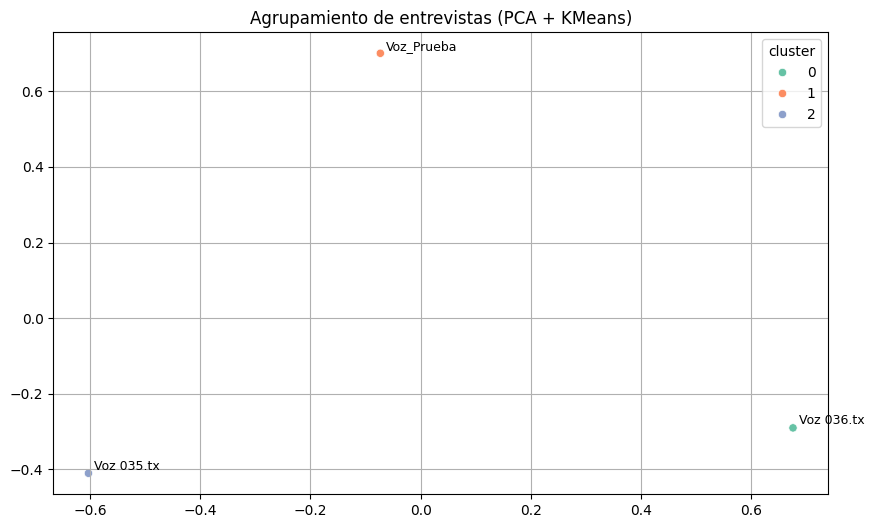

In [ ]:
pca = PCA(n_components=2)
coords = pca.fit_transform(tfidf.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=df_datos['cluster'], palette='Set2')
for i, archivo in enumerate(df_datos['archivo']):
    plt.text(coords[i,0]+0.01, coords[i,1]+0.01, archivo[:10], fontsize=9)
plt.title("Agrupamiento de entrevistas (PCA + KMeans)")
plt.grid(True)
plt.show()

## 7. Visualización del sentimiento por entrevista

<ipython-input-7-de6c3f823a77>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_datos, x='archivo', y='sentimiento', palette='coolwarm')


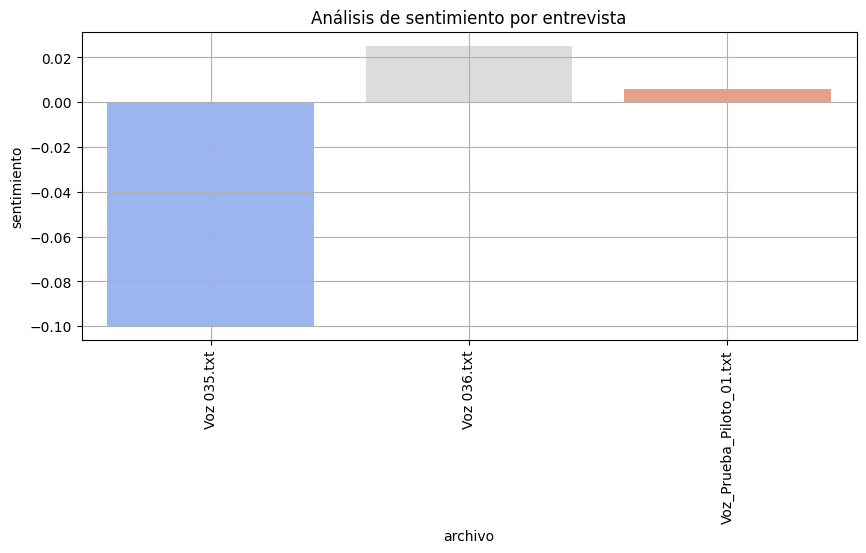

In [ ]:
plt.figure(figsize=(10,4))
sns.barplot(data=df_datos, x='archivo', y='sentimiento', palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Análisis de sentimiento por entrevista")
plt.grid(True)
plt.show()

## 8. Exportar datos finales

In [ ]:
df_datos.to_csv("resultados_finales_sentimiento_clusters.csv", index=False)
print("Exportado como resultados_finales_sentimiento_clusters.csv")

Exportado como resultados_finales_sentimiento_clusters.csv


## 9. Conclusión

Este notebook maestro permite un análisis integrado de múltiples entrevistas: análisis textual, sentimiento, agrupamiento y visualizaciones. Puede extenderse a mapas temáticos, dashboards o análisis temporal si se requiere.